# Getting started with the local emulator

Amazon Braket is launching a local emulator feature which will enable customers to:
1. Emulate quantum devices supported on Braket with real-time calibirated noise parameters
2. Perform noisy simulation with custom noise parameters including historically saved device parameters

This notebook will walk you through the steps to utilize the local emulator for both use cases. For now the local emulator is only supported for verbatim circuits.

## 1. Using the local emulator to emulate quantum hardware with live noise parameters

### a. Working example

Let's start with the imports and initialinzing the emulator. Here, we will be using Rigetti's [Ankaa-3]() device.

In [130]:
import os
import certifi
os.environ['SSL_CERT_FILE'] = certifi.where()
os.environ['REQUESTS_CA_BUNDLE'] = certifi.where()
os.environ['AWS_CA_BUNDLE'] = certifi.where()

from braket.aws.aws_device import AwsDevice
from braket.circuits import Circuit
from braket.devices import LocalSimulator

import numpy as np
from numpy import pi as pi

from matplotlib import pyplot as plt

ankaa3 = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-3")
ankaa3_emulator = ankaa3.emulator()

Since the local emulator currently only supports verbatim circuits, we examine Ankaa-3's native gates

In [39]:
native_gates = ankaa3.properties.paradigm.nativeGateSet
print(f"Native gates for {ankaa3.name}: {native_gates}")

Native gates for Ankaa-3: ['rx', 'rz', 'iswap']


Now we create and visualize an arbitrary 4-qubit quantum circuit with the help of the native gates

In [117]:
verbatim_circuit = Circuit().add_verbatim_box(
    Circuit().rx(0, pi/2).rz(1, pi).iswap(0, 1).rx(2, -pi/2).rz(3, pi/2).iswap(2, 3).iswap(1, 2).rx(0, -pi/2).rz(3, -pi)
)
print(verbatim_circuit)

T  : │        0        │      1      │    2    │      3      │       4       │
                        ┌──────────┐  ┌───────┐ ┌───────────┐                 
q0 : ───StartVerbatim───┤ Rx(1.57) ├──┤ ISWAP ├─┤ Rx(-1.57) ├───EndVerbatim───
              ║         └──────────┘  └───┬───┘ └───────────┘        ║        
              ║         ┌──────────┐  ┌───┴───┐   ┌───────┐          ║        
q1 : ─────────║─────────┤ Rz(3.14) ├──┤ ISWAP ├───┤ ISWAP ├──────────║────────
              ║         └──────────┘  └───────┘   └───┬───┘          ║        
              ║         ┌───────────┐ ┌───────┐   ┌───┴───┐          ║        
q2 : ─────────║─────────┤ Rx(-1.57) ├─┤ ISWAP ├───┤ ISWAP ├──────────║────────
              ║         └───────────┘ └───┬───┘   └───────┘          ║        
              ║         ┌──────────┐  ┌───┴───┐ ┌───────────┐        ║        
q3 : ─────────╨─────────┤ Rz(1.57) ├──┤ ISWAP ├─┤ Rz(-3.14) ├────────╨────────
                        └──────────┘  └───────┘ └───

Next, can run the circuit and retrieve the results

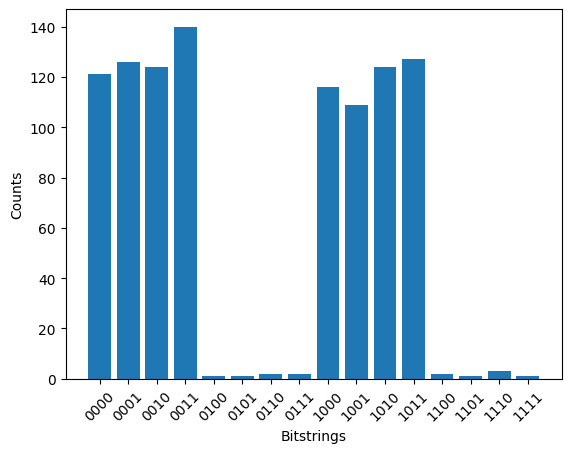

In [118]:
emulator_run = ankaa3_emulator.run(verbatim_circuit, shots=1000)
emulator_result = emulator_run.result()
emulator_counts = emulator_result.measurement_counts

plt.bar(sorted(emulator_counts.keys()), [emulator_counts[k] for k in sorted(emulator_counts.keys())])
plt.xlabel("Bitstrings")
plt.ylabel("Counts")
plt.xticks(rotation=45)
plt.show()

That ran successfuly, great! But let's see how this could run into trouble.

### b. Invalid examples

Under the hood, what the local emulator is doing is that it first validates the verbatim circuit

In [97]:
ankaa3_emulator.validate(verbatim_circuit)

and then transforms the circuit into a noisy circuit using the device noise parameters

In [98]:
noisy_circ =  ankaa3_emulator.transform(verbatim_circuit)
print(noisy_circ)

T  : │        0        │              1               │            2             │              3               │       4       │
                        ┌──────────┐ ┌───────────────┐ ┌───────┐ ┌─────────────┐  ┌──────────┐ ┌───────────────┐                 
q0 : ───StartVerbatim───┤ Rx(1.57) ├─┤ DEPO(0.00034) ├─┤ ISWAP ├─┤ DEPO(0.022) ├──┤ Rx(4.71) ├─┤ DEPO(0.00034) ├───EndVerbatim───
              ║         └──────────┘ └───────────────┘ └───┬───┘ └──────┬──────┘  └──────────┘ └───────────────┘        ║        
              ║         ┌──────────┐ ┌──────────────┐  ┌───┴───┐ ┌──────┴──────┐   ┌───────┐    ┌─────────────┐         ║        
q1 : ─────────║─────────┤ Rz(3.14) ├─┤ DEPO(0.0007) ├──┤ ISWAP ├─┤ DEPO(0.022) ├───┤ ISWAP ├────┤ DEPO(0.015) ├─────────║────────
              ║         └──────────┘ └──────────────┘  └───────┘ └─────────────┘   └───┬───┘    └──────┬──────┘         ║        
              ║         ┌──────────┐ ┌───────────────┐ ┌───────┐ ┌──────────────┐  ┌───┴──

and finally run the noisy circuit using the [local density matrix simulator](https://docs.aws.amazon.com/braket/latest/developerguide/braket-submit-tasks-simulators.html#braket-simulator-dm) (see [this notebook](https://github.com/amazon-braket/amazon-braket-examples/blob/main/examples/braket_features/Simulating_Noise_On_Amazon_Braket.ipynb) for more details on noisy simulator).

However, there are three main reasons the validation step could fail:
1. Using qubits that do not exist on the device
2. Using gates that are not part of the device native set
3. Applying two-qubit gates on qubits that are not connected in the device's topology

Below we illustrate those cases.

#### i. Qubit doesn't exist on the device

Ankaa-3 has 84 qubits numbered 0-83, so applying a gate on qubit 84 will throw an error

In [105]:
invalid_circuit = Circuit().add_verbatim_box(
    Circuit().rx(84, pi/2)
)

try:
    result = ankaa3_emulator.run(invalid_circuit, shots=1000)
    print("Success!")
except Exception as e:
    print(f"Failure with error message: {str(e)}")

Failure with error message: Qubit Qubit(84) does not exist in the device topology. (DeviceEmulator)


#### ii. Using non-native gates

As we have seen above, the native gate set for Ankaa-3 is rx, rz, and iswap. Thus, if we apply a Hadamard gate we will get an error

In [106]:
invalid_circuit = Circuit().add_verbatim_box(
    Circuit().h(0)
)

try:
    result = ankaa3_emulator.run(invalid_circuit, shots=1000)
    print("Success!")
except Exception as e:
    print(f"Failure with error message: {str(e)}")


Failure with error message: Gate H is not a native gate for this device. (DeviceEmulator)


#### iii. Applying two-qubit gates on unconnected qubits

On Ankaa-3, qubits 0 and 2 are not connected, so we cannot apply a two qubit gate on them

In [107]:
invalid_circuit = Circuit().add_verbatim_box(
    Circuit().iswap(0, 2)
)

try:
    result = ankaa3_emulator.run(invalid_circuit, shots=1000)
    print("Success!")
except Exception as e:
    print(f"Failure with error message: {str(e)}")


Failure with error message: 0 is not connected to qubit 2 in this device. (DeviceEmulator)


### c. Comparing emulator results to noiseless simulation and Ankaa-3 device

Next, we want to see how well does the emulator capture the device results as compared to the noiseless simulator. Let's start by getting the emulator and device results

In [120]:
local_sim = LocalSimulator()

sim_run = local_sim.run(verbatim_circuit, shots=1000).result()
sim_counts = sim_run.measurement_counts

In [122]:
device_run = ankaa3.run(verbatim_circuit, shots=1000)

In [128]:
device_counts = device_run.result().measurement_counts

And now we plot all the results to visualize them

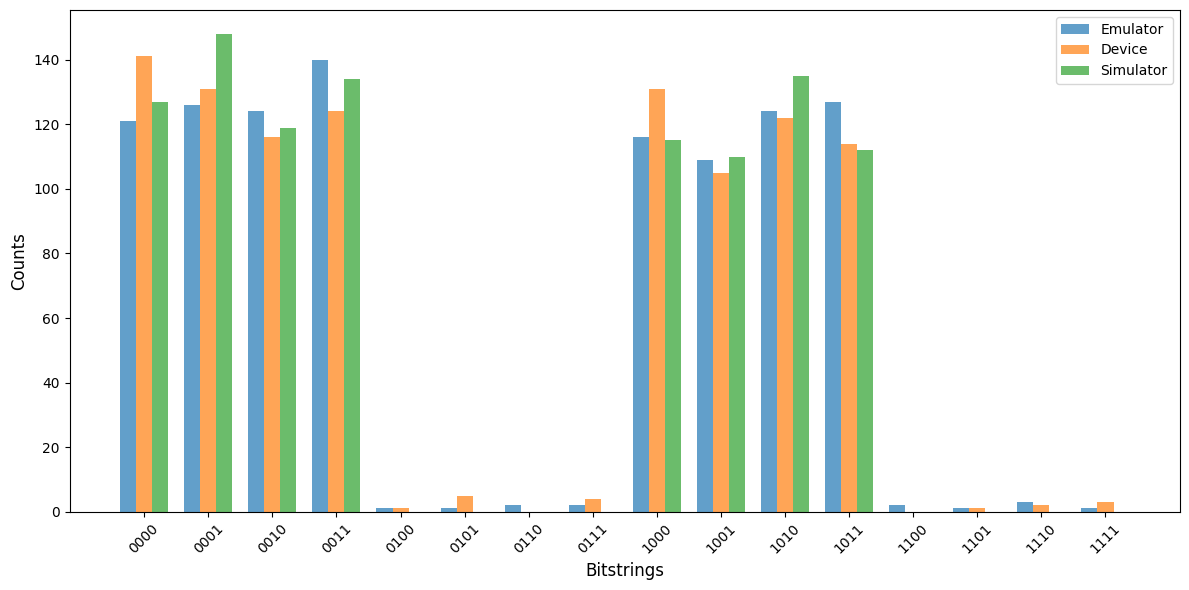

In [144]:
all_bitstrings = sorted(set(list(emulator_counts.keys()) + 
                            list(device_counts.keys()) + 
                            list(sim_counts.keys())))

fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.25
x = np.arange(len(all_bitstrings))

emulator_bars = ax.bar(x - bar_width, 
                        [emulator_counts.get(b, 0) for b in all_bitstrings], 
                        bar_width, label='Emulator', alpha=0.7)

device_bars = ax.bar(x, 
                    [device_counts.get(b, 0) for b in all_bitstrings], 
                    bar_width, label='Device', alpha=0.7)

sim_bars = ax.bar(x + bar_width, 
                [sim_counts.get(b, 0) for b in all_bitstrings], 
                bar_width, label='Simulator', alpha=0.7)

ax.set_xlabel('Bitstrings', fontsize=12)
ax.set_ylabel('Counts', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(all_bitstrings, rotation=45)
ax.legend()
plt.tight_layout()
plt.show()